In [1]:
import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.path import Path

from scipy.stats import gaussian_kde, chi2, norm

from gdt.missions.fermi.gbm.localization import GbmHealPix

from tqdm import tqdm
from glob import glob

from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse, Circle

from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier

import matplotlib
# matplotlib.use('Agg')  

Vizier.ROW_LIMIT = -1  # return all rows

%matplotlib widget

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# plt.rc('font', size=15)
# plt.rc('xtick', labelsize=15)
# plt.rc('ytick', labelsize=15)

fig_width_pt = 244.0  # Get this from LaTeX using \the\columnwidth
text_width_pt = 508.0 # Get this from LaTeX using \the\textwidth

inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt*1.5 # width in inches
fig_width_full = text_width_pt*inches_per_pt  # 17
fig_height =fig_width*golden_mean # height in inches
fig_size = [fig_width,fig_height] #(9,5.5) #(9, 4.5)

fig_size_full = [fig_width,fig_height] #(9,5.5) #(9, 4.5)

In [3]:
catalogue_1 = Vizier.get_catalogs("J/A+A/675/A199")[0]
catalogue_2 = Vizier.get_catalogs("J/A+A/677/A134")[0]

xrb_ras_1 = catalogue_1.to_pandas()['RA_ICRS'].values
xrb_decs_1 = catalogue_1.to_pandas()['DE_ICRS'].values

xrb_ras_2 = catalogue_2.to_pandas()['RA_ICRS'].values
xrb_decs_2 = catalogue_2.to_pandas()['DE_ICRS'].values

In [4]:
folder = '/Users/zgl12/Research/Sn2019vxm/Fermi/'

healpix_file = glob(folder + '*healpix*')[0]
loc = GbmHealPix.open(healpix_file)

def wrap_ra_centered(ra, ra_center):
    # Shift RA so that ra_center is in the middle of the range
    wrapped = (ra - ra_center + 180) % 360 - 180
    return wrapped + ra_center

def normalize_ra(ra):
    return ra % 360

def reflect_dec(dec):
    """Reflect declination across the poles into [-90, 90]."""
    # This handles arbitrarily large excursions
    dec = ((dec + 90) % 360) - 90  
    if dec > 90:
        dec = 180 - dec
    if dec < -90:
        dec = -180 - dec
    return dec

ra = 299.6189
dec = 62.1377

ra0 = 297.9
dec0 = 76.4

abs_df = pd.DataFrame(columns =['RA', 'RA_wrap', 'Dec', 'Prob'])

# abs_df['RA_wrapped'] = wrap_ra_centered(abs_df['RA'].values, ra_center)

d_ra  = np.linspace(-180, 180, 201)
d_dec = np.linspace(-30, 30, 201)

for dra in tqdm(d_ra, desc='Calculating probabilities'):
    for ddec in d_dec:
        ra_wrap  = wrap_ra_centered(ra + dra, ra)
        ra_test = normalize_ra(ra + dra)
        p = loc.probability(ra_test, reflect_dec(dec + ddec))
        abs_df = pd.concat([abs_df,
                            pd.DataFrame({'RA':[ra + dra], 'RA_wrap':[ra_wrap], 'Dec':[reflect_dec(dec + ddec)], 'Prob':[p]})],
                           ignore_index=True)

Calculating probabilities:   0%|          | 0/201 [00:00<?, ?it/s]/var/folders/6v/pg_c9mqn3gn45gn_zmvy9w9cvfsx9j/T/ipykernel_11540/1804862438.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  abs_df = pd.concat([abs_df,
Calculating probabilities: 100%|██████████| 201/201 [00:07<00:00, 26.37it/s]


[297.8189     299.6189     301.4189     302.97025583 303.2189
 304.80851244 305.0189     306.14562939 306.8189     307.32418042
 308.37245754 308.6189     309.33418203 310.23279956 310.4189
 311.07914684 311.87276035 312.2189     312.64542183 313.39726613
 314.0189     314.13482383 314.91409463 315.6734655  315.8189
 316.49845914 317.33358086 317.6189     318.24150782 319.15205768
 319.4189     320.11073344 321.06036872 321.2189     322.05855335
 323.0189     323.03345928 324.06951071 324.8189     325.08809493
 326.1266977  326.6189     327.19608404 328.2464663  328.4189
 329.33029962 330.2189     330.38206219 331.44929904 332.0189
 332.48469238 333.55426253 333.8189     334.63692719 335.6189
 335.68642008 336.80059255 337.4189     337.93499631 339.10054606
 339.2189     340.33601566 341.0189     341.59454628 342.8189
 342.88583448 344.25545497 344.6189     345.67605907 346.4189
 347.1466396  348.2189     348.64984479 350.0189     350.1797243
 351.72955383 351.8189     353.28637358 353

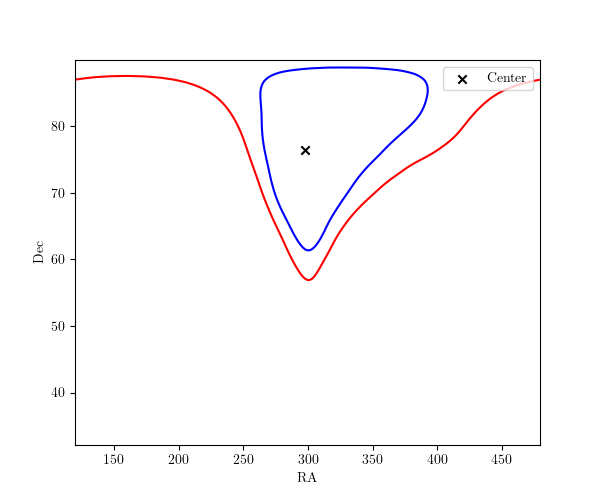

In [5]:
def get_contour_paths(xx, yy, f, levels):
    """
    Extract contour line coordinates for given probability levels.

    Args:
        xx, yy : 2D meshgrid arrays
        f : 2D array of values (probability map)
        levels : list of cumulative probability levels (e.g., [0.68, 0.95])

    Returns:
        contours : dict mapping each level -> list of (N,2) arrays of contour vertices
        p_levels : list of probability density thresholds corresponding to each level
    """
    # Normalize probabilities
    f = f / np.sum(f)

    # Compute probability density thresholds for given cumulative levels
    sorted_probs = np.sort(f.flatten())[::-1]
    cum_probs = np.cumsum(sorted_probs)
    p_levels = [sorted_probs[np.searchsorted(cum_probs, lev)] for lev in levels]

    # Create contour set (don't display)
    fig, ax = plt.subplots()
    cs = ax.contour(xx, yy, f, levels=p_levels)

    # Extract vertices
    contours = {lev: [seg.copy() for seg in segs] 
                for lev, segs in zip(levels, cs.allsegs)}

    plt.close(fig)
    return contours, p_levels

def make_prob_grid(abs_df):
    """
    Convert 1D RA, Dec, Prob dataframe into 2D gridded arrays.
    Returns (X, Y, Prob_grid)
    """
    # Build 2D probability grid using pivot
    pivot = abs_df.pivot(index='Dec', columns='RA', values='Prob')
    x_unique = pivot.columns.values
    y_unique = pivot.index.values
    X, Y = np.meshgrid(x_unique, y_unique)
    return X, Y, pivot.values

def wrap_contour_path(xs, ys, wrap_center=180):
    """
    Wrap RA-like coordinate contour paths so that they remain continuous.
    xs: array of RA values (degrees)
    ys: array of Dec values
    wrap_center: 180 → RA range will be (0, 360)
    Returns wrapped (xs, ys)
    """
    xs_wrapped = np.mod(xs - wrap_center, 360) + wrap_center
    xs_wrapped = np.mod(xs_wrapped, 360)  # ensure 0–360
    
    print(xs_wrapped)
    
    # Detect discontinuities > 180° (wrap crossings)
    diffs = np.diff(xs_wrapped)
    jumps = np.where(np.abs(np.diff(xs_wrapped)) > 180)[0]
    
    if len(jumps) > 0:
        # Shift the smaller segment to make continuous
        for idx in jumps:
            if xs_wrapped[idx] > 180:
                xs_wrapped[idx+1:] -= 360
            else:
                xs_wrapped[idx+1:] += 360

    # Ensure closed loop
    if not (xs_wrapped[0] == xs_wrapped[-1] and ys[0] == ys[-1]):
        print("Closing contour loop")
        xs_wrapped = np.append(xs_wrapped, xs_wrapped[0])
        ys = np.append(ys, ys[0])
        
    return xs_wrapped, ys

X, Y, prob_grid = make_prob_grid(abs_df)

contours, p_levels = get_contour_paths(X, Y, prob_grid, levels=[0.95, 0.68])

# You can now access the coordinate arrays like:
contour_68 = np.array(contours[0.68][0])#.squeeze()  # list of (N,2) arrays
contour_95 = np.array(contours[0.95][0])#.squeeze()


# Wrap and close them
xs68, ys68 = wrap_contour_path(contour_68[:,0], contour_68[:,1])
xs95, ys95 = wrap_contour_path(contour_95[:,0], contour_95[:,1])

cont68 = np.column_stack([xs68, ys68])
cont95 = np.column_stack([xs95, ys95])


# Optional: plot
plt.figure(figsize=(6,5))
plt.contour(X, Y, prob_grid / np.sum(prob_grid), levels=p_levels, colors=['r','b'])
plt.scatter(ra0, dec0, color='k', marker='x', label='Center')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.legend()
plt.show()


In [6]:
def update_map(nside, theta_center, phi_center, uncertainty_rad, map_data):
    ipix = np.arange(hp.nside2npix(nside))
    
    theta, phi = hp.pix2ang(nside, ipix)
    
    angular_distances = hp.rotator.angdist((theta_center, phi_center), (theta, phi))
    
    map_data[angular_distances <= 2 * uncertainty_rad] = 0.35
    map_data[angular_distances <= uncertainty_rad] = 0.70
    
    map_data[map_data == 0] = np.nan
    
    return map_data


In [7]:
# Yellow line
# magenta line
# More adaptive error

In [8]:
def radec_to_rad(ra_deg, dec_deg):
    return np.radians(ra_deg), np.radians(dec_deg)

def rad_to_radec(ra_rad, dec_rad):
    return np.degrees(ra_rad), np.degrees(dec_rad)

def mean_radec_of_contour(contour):
    """
    Get a stable centre for a contour in RA/Dec (deg).
    We average unit vectors and re-normalize to get a good tangent centre.
    """
    ra = np.radians(contour[:,0])
    dec = np.radians(contour[:,1])
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    v = np.array([x, y, z]).T.mean(axis=0)
    v /= np.linalg.norm(v)
    dec0 = np.arcsin(v[2])
    ra0 = np.arctan2(v[1], v[0])
    ra0_deg, dec0_deg = np.degrees(ra0) % 360, np.degrees(dec0)
    return ra0_deg, dec0_deg

def gnomonic_project(ra_deg, dec_deg, ra0_deg, dec0_deg):
    """
    Gnomonic projection of points (ra,dec) onto tangent plane at (ra0,dec0).
    Returns (x, y) arrays in dimensionless units (tan of angle).
    Points exactly at the antipode of the centre will map with cos_c <= 0;
    we mark those as invalid (return nan).
    Formula based on Snyder / standard gnomonic projection.
    """
    ra, dec = np.radians(ra_deg), np.radians(dec_deg)
    ra0, dec0 = np.radians(ra0_deg), np.radians(dec0_deg)
    d_ra = ra - ra0

    sin_dec = np.sin(dec); cos_dec = np.cos(dec)
    sin_dec0 = np.sin(dec0); cos_dec0 = np.cos(dec0)

    cos_c = sin_dec0 * sin_dec + cos_dec0 * cos_dec * np.cos(d_ra)
    # If cos_c <= 0 point is on or beyond the horizon of the tangent plane (antipodal side)
    # mark as invalid (numpy will handle division by zero)
    x = cos_dec * np.sin(d_ra) / cos_c
    y = (cos_dec0 * sin_dec - sin_dec0 * cos_dec * np.cos(d_ra)) / cos_c

    # Mask invalid points (cos_c <= 0)
    invalid = cos_c <= 0
    if np.isscalar(x):
        if invalid:
            return np.nan, np.nan
        return x, y
    x = np.where(invalid, np.nan, x)
    y = np.where(invalid, np.nan, y)
    return x, y

# -------------------------
# Main mask function
# -------------------------
def healpix_mask_from_contours(nside, contours, pix_centered=True, return_map=False):
    """
    Build HEALPix boolean masks from contour(s).

    Args:
        nside : int
        contours : list of contours OR single Nx2 numpy array
                   each contour = array of shape (M,2) with columns [RA_deg, Dec_deg].
        pix_centered : if True use pixel centers (default True)
        return_map : if True, also return a float map where:
                     nan = outside, 0.35 = inside 95%, 0.70 = inside 68% (when 2 contours provided)

    Returns:
        masks : list of boolean masks (one per contour) or single boolean array if single contour input
        optionally map_out : float array for visualization (only when return_map True and 1 or 2 contours)
    """
    # Normalize input to list of contours
    single_input = False
    if isinstance(contours, np.ndarray):
        contours = [contours]
        single_input = True
    elif not isinstance(contours, (list, tuple)):
        raise ValueError("contours must be an (N,2) array or a list of such arrays")

    npix = hp.nside2npix(nside)
    # Pixel centers in healpy: theta (colat), phi (lon) in radians
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    # Convert to RA, Dec degrees: phi [0..2pi) -> RA, Dec = 90 - theta (in deg)
    ra_pix = np.degrees(phi) % 360.0
    dec_pix = 90.0 - np.degrees(theta)

    masks = []
    for cont in contours:
        # ensure closed contour (first == last)
        if not (cont[0,0] == cont[-1,0] and cont[0,1] == cont[-1,1]):
            cont = np.vstack([cont, cont[0]])
        # choose a projection centre near the contour (robust even with RA wrap)
        ra0, dec0 = mean_radec_of_contour(cont)
        # project contour and pixels into gnomonic plane about (ra0,dec0)
        cx, cy = gnomonic_project(cont[:,0], cont[:,1], ra0, dec0)
        px, py = gnomonic_project(ra_pix, dec_pix, ra0, dec0)

        # Build 2D Path using only valid (finite) contour points
        valid = np.isfinite(cx) & np.isfinite(cy)
        if np.sum(valid) < 3:
            # degenerate: contour projects badly (e.g., encircles antipode). mark all False
            masks.append(np.zeros(npix, dtype=bool))
            continue

        path = Path(np.vstack([cx[valid], cy[valid]]).T, closed=True)

        pts = np.vstack([px, py]).T  # shape (npix, 2)
        # points with NaNs are outside by construction
        finite_pts = np.isfinite(pts).all(axis=1)

        inside = np.zeros(npix, dtype=bool)
        if finite_pts.any():
            inside[finite_pts] = path.contains_points(pts[finite_pts])

        masks.append(inside)

    # Return single mask directly if single input
    if single_input:
        masks = masks[0]

    if return_map:
        # If 1 or 2 contours provided we can build the visualization map:
        map_out = np.full(npix, np.nan, dtype=float)
        if isinstance(masks, list) and len(masks) >= 1:
            # if second provided we'll treat first as 68% (inner) and second as 95% (outer)
            if len(masks) == 1:
                map_out[masks[0]] = 0.70
            else:
                # assume contours order: inner (68), outer (95) OR user-specified
                mask68, mask95 = masks[0], masks[1]
                map_out[mask95] = 0.35
                map_out[mask68] = 0.70
        else:
            # single mask
            map_out[masks] = 0.70
        return masks, map_out

    return masks


In [9]:
nside = 256  # Healpix resolution

masks, map_out = healpix_mask_from_contours(nside, [cont68, cont95], return_map=True)

mask68, mask95 = masks

/Users/zgl12/anaconda3/lib/python3.11/site-packages/healpy/visufunc.py:200: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  f = pylab.figure(fig, figsize=(8.5, 5.4))


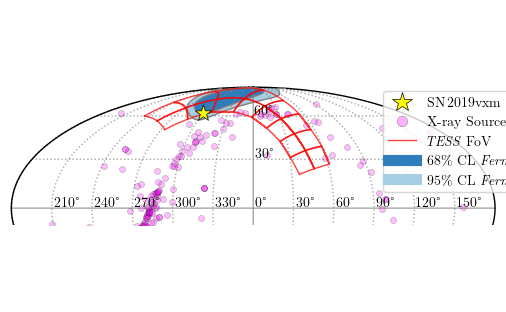

In [10]:

cmap = cm.Blues
# cmap.set_under('white', 1)  # Set the color for values below the lowest value to white

sne_ra = 299.618917 
sne_dec = 62.137731
ra0 = 297.9
dec0 = 76.4
uncertainty = 9.1

ra_rad = np.radians(ra0)
dec_rad = np.radians(dec0)
uncertainty_rad = np.radians(uncertainty)

nside = 256  # Healpix resolution
npix = hp.nside2npix(nside)
map_data = np.zeros(hp.nside2npix(nside))  # Blank map for illustration

theta, phi = hp.pix2ang(nside, np.arange(npix))
decs = np.rad2deg(0.5*np.pi - theta)
ras  = np.rad2deg(phi)

theta_center = np.pi / 2 - dec_rad 
phi_center = ra_rad 

new_map_data = map_out.copy()

# Masking the Southern Hemisphere (lat < 0) by setting those pixels to UNSEEN
theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
latitudes = np.pi / 2 - theta  # Convert to latitude (0 at the equator, positive in the north)

# Mask all pixels with latitude < 0 (Southern Hemisphere)
map_data[latitudes < 0] = hp.UNSEEN  # Set to UNSEEN to exclude from the plot

fig = plt.figure(figsize = fig_size)

hp.mollview(new_map_data, cmap=cmap, unit="Shaded Area", title="",
            min=0, max=1, cbar=False, coord=None, rot=0, fig = fig,
            flip='geo', badcolor='white')

hp.graticule(dpar=30, dmer=30, color='gray', linewidth=1.2, alpha=0.7)

folder = '../Telescopes_Scripts/TESS/TESS_Outlines/'

for cam in range(1, 5):
    for ccd in range(1, 5):
        ras = np.load(folder + f's18_{cam}_{ccd}_ras.npy')
        decs = np.load(folder + f's18_{cam}_{ccd}_decs.npy')

        hp.visufunc.projplot(ras, decs, lonlat=True, c='r', alpha=0.75, linewidth=1, zorder = 10)

def spherical_circle(lat0, lon0, radius, num_points=360):
    """
    Draw a spherical circle on the map.
    :param lat0: Latitude of the center of the circle in radians.
    :param lon0: Longitude of the center of the circle in radians.
    :param radius: Radius of the circle in radians.
    :param num_points: Number of points to use for the circle.
    :return: None
    """
    theta = np.linspace(0, 2*np.pi, num_points)
    lats = np.degrees(np.arcsin(np.sin(lat0) * np.cos(radius) + np.cos(lat0) * np.sin(radius) * np.cos(theta)))
    lons = np.degrees(lon0 + np.arctan2(np.sin(theta) * np.sin(radius) * np.cos(lat0), np.cos(radius) - np.sin(lat0) * np.sin(np.radians(lats))))
    lons = (lons + 360) % 360
    hp.visufunc.projplot(lons, lats, lonlat=True, color='gray', linewidth=1, alpha=1)

hp.visufunc.projplot(contour_95[:,0], contour_95[:,1], lonlat=True, color='gray', linewidth=1, alpha=1)
hp.visufunc.projplot(contour_68[:,0], contour_68[:,1], lonlat=True, color='gray', linewidth=1, alpha=1)

for lon in [30, 60, 90, 120, 150, 210, 240, 270, 300, 330]:
    hp.visufunc.projtext(lon + 1.5, 1.5, f"{int(lon)}°", lonlat=True, fontsize=10, color='black', zorder=15)

for lat in [0, 30, 60]:  # Only plotting latitudes of 0, 30, and 60 for better Northern Hemisphere focus
    hp.visufunc.projtext(1.5, lat + 1.5, f"{int(lat)}°", lonlat=True, fontsize=10, color='black', zorder=15)

# spherical_circle(dec_rad, ra_rad, uncertainty_rad, num_points=360)
# spherical_circle(dec_rad, ra_rad, 2*uncertainty_rad, num_points=360)

hp.visufunc.projscatter(sne_ra, sne_dec, lonlat=True, c='yellow', s=150, 
                        marker='*', edgecolors='k', linewidth=0.5, zorder=30)

hp.visufunc.projscatter(xrb_ras_1, xrb_decs_1, lonlat=True, c='magenta', s=75, 
                        marker='.', edgecolors='k', linewidth=0.5, zorder=5, alpha = 0.25)
hp.visufunc.projscatter(xrb_ras_2, xrb_decs_2, lonlat=True, c='magenta', s=75, 
                        marker='.', edgecolors='k', linewidth=0.5, zorder=5, alpha = 0.25)

legend_handles = []
handle1 = Line2D([0], [0], marker='*', color='yellow', markersize=15, linestyle='None', markeredgecolor='k', markeredgewidth=0.5, label=r'SN$\,$2019vxm')
legend_handles.append(handle1)

handle_x = Line2D([0], [0], marker='.', color='magenta', markersize=15, linestyle='None', markeredgecolor='k', markeredgewidth=0.5, 
                alpha = 0.3, label='X-ray Sources')
legend_handles.append(handle_x)

handle2 = Line2D([0], [1], color='r', linewidth=1, alpha=0.75, label=r'\textit{TESS} FoV')
legend_handles.append(handle2)

cmap = plt.get_cmap('Blues')

blues_marker_70 = cmap(0.7)
handle4 = Line2D([0], [1], color=blues_marker_70, linewidth=8, label=r'$68\%$ CL \textit{Fermi} GBM')
legend_handles.append(handle4)

blues_marker_35 = cmap(0.35)
handle3 = Line2D([0], [1], color=blues_marker_35, linewidth=8, label=r'$95\%$ CL \textit{Fermi} GBM')
legend_handles.append(handle3)

for artist in fig.get_children():
    if hasattr(artist, 'set_rasterized'):
        artist.set_rasterized(True)

plt.legend(bbox_to_anchor=(0.95, 0.6), loc='center', handles=legend_handles, ncol = 1)
plt.ylim(-np.radians(8), None)
plt.savefig("../Plots/northern_hemisphere_sky_map.pdf", bbox_inches='tight', format='pdf')
plt.show()


In [11]:
import numpy as np
from shapely.geometry import Polygon
from spherical_geometry.polygon import SphericalPolygon

# Load your region

def remove_duplicates(ra, dec):
    coords = np.column_stack([ra, dec])
    _, idx = np.unique(coords, axis=0, return_index=True)
    coords_unique = coords[np.sort(idx)]
    return coords_unique[:,0], coords_unique[:,1]

def ra_dec_to_xy(ra, dec, ra0, dec0):
    """Simple gnomonic projection"""
    ra, dec, ra0, dec0 = map(np.radians, [ra, dec, ra0, dec0])
    cosc = np.sin(dec0)*np.sin(dec) + np.cos(dec0)*np.cos(dec)*np.cos(ra-ra0)
    x = np.cos(dec) * np.sin(ra-ra0) / cosc
    y = (np.cos(dec0)*np.sin(dec) - np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)) / cosc
    return x, y

fracs_apx = []
fracs_sph = []

x_cont, y_cont = ra_dec_to_xy(cont95[:,0], cont95[:,1], ra0, dec0)
cont_ra, cont_dec = remove_duplicates(cont68[:,0], cont68[:,1])
cont_poly = Polygon(np.column_stack([x_cont, y_cont]))

for ccd in tqdm(range(1, 5), desc='Processing CCDs'):
    for cam in range(1, 5):

        region_ra = np.load(f'/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/TESS_Outlines/s18_{cam}_{ccd}_ras.npy')
        region_dec = np.load(f'/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/TESS_Outlines/s18_{cam}_{ccd}_decs.npy')

        # Center for projection
        
        # x_cont, y_cont = cont68[:,0], cont68[:,1]
        x_reg, y_reg = ra_dec_to_xy(region_ra, region_dec, ra0, dec0)
        # x_reg, y_reg = region_ra, region_dec
        
        region_ra, region_dec = remove_duplicates(region_ra, region_dec)

        # Create polygons
        
        reg_poly = Polygon(np.column_stack([x_reg, y_reg]))

        # Fix invalid polygons
        cont_poly = cont_poly.buffer(0)
        reg_poly = reg_poly.buffer(0)

        # Compute intersection and fraction
        intersection = cont_poly.intersection(reg_poly)
        fraction_apx = intersection.area / cont_poly.area
        print(f"Fraction covered (approx): {fraction_apx:.4f}")
        
        # # Convert contour RA/Dec to radians
        # cont_sp = SphericalPolygon.from_radec(np.radians(cont_ra), np.radians(cont_dec))

        # # Convert CCD polygon to spherical polygon
        # reg_sp = SphericalPolygon.from_radec(np.radians(region_ra), np.radians(region_dec))

        # # Compute intersection fraction
        # intersection_sp = cont_sp.intersection(reg_sp)
        # fraction = intersection_sp.area() / cont_sp.area()
        # print(f"Fraction covered (spherical): {fraction:.4f}")
        
        fracs_apx.append(fraction_apx)
        # fracs_sph.append(fraction)

np.nansum(fracs_apx), np.nansum(fracs_sph)

Processing CCDs: 100%|██████████| 4/4 [00:00<00:00, 72.23it/s]

Fraction covered (approx): 0.0000
Fraction covered (approx): 0.0000
Fraction covered (approx): 0.0358
Fraction covered (approx): 0.1774
Fraction covered (approx): 0.0000
Fraction covered (approx): 0.0000
Fraction covered (approx): 0.1301
Fraction covered (approx): 0.1261
Fraction covered (approx): 0.0000
Fraction covered (approx): 0.0000
Fraction covered (approx): 0.1810
Fraction covered (approx): 0.0000
Fraction covered (approx): 0.0000
Fraction covered (approx): 0.0000
Fraction covered (approx): 0.1688
Fraction covered (approx): 0.0000


(0.8192253392088189, 0.0)

In [ ]:
# # Function to convert RA/Dec polygon to HEALPix pixels
# def polygon_to_healpix(ra, dec, nside):
#     """
#     ra, dec in degrees
#     Returns HEALPix pixel indices covering the polygon
#     """
#     import matplotlib.path as mpath
#     # Convert RA/Dec to theta/phi
#     theta = np.radians(90 - dec)  # colatitude
#     phi = np.radians(ra)
    
#     # Generate HEALPix pixel centers
#     npix = hp.nside2npix(nside)
#     pix_theta, pix_phi = hp.pix2ang(nside, np.arange(npix))
    
#     # Convert to RA/Dec degrees
#     pix_ra = np.degrees(pix_phi)
#     pix_dec = 90 - np.degrees(pix_theta)
    
#     # Create 2D path for polygon
#     path = mpath.Path(np.column_stack([ra, dec]))
    
#     # Check which pixel centers are inside polygon
#     inside = path.contains_points(np.column_stack([pix_ra, pix_dec]))
#     pix_inside = np.arange(npix)[inside]
    
#     return pix_inside

# nside = 2560
# fracs = []

# # for ccd in tqdm(range(1, 5), desc='Processing CCDs'):
# #     for cam in range(1, 5):

# #         region_ra = np.load(f'/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/TESS_Outlines/s18_{cam}_{ccd}_ras.npy')
# #         region_dec = np.load(f'/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/TESS_Outlines/s18_{cam}_{ccd}_decs.npy')

# #         # Center for projection
        
# #         # x_cont, y_cont = cont68[:,0], cont68[:,1]
# #         x_reg, y_reg = ra_dec_to_xy(region_ra, region_dec, ra0, dec0)
# #         # x_reg, y_reg = region_ra, region_dec
        
# #         cont_ra, cont_dec = remove_duplicates(cont68[:,0], cont68[:,1])
# #         region_ra, region_dec = remove_duplicates(region_ra, region_dec)

# #         cont_pixels = polygon_to_healpix(cont_ra, cont_dec, nside)

# #         # Example CCD region polygon
# #         reg_pixels = polygon_to_healpix(region_ra, region_dec, nside)

# #         # Compute fraction of contour pixels covered
# #         fraction = np.isin(cont_pixels, reg_pixels).sum() / len(cont_pixels)
# #         print(f"Fraction covered: {fraction:.4f}")
# #         fracs.append(fraction)

# # print("Total fraction covered:", np.nansum(fracs))


# x_cont, y_cont = ra_dec_to_xy(cont68[:,0], cont68[:,1], ra0, dec0)
# cont_ra, cont_dec = remove_duplicates(cont68[:,0], cont68[:,1])
# cont_pixels = polygon_to_healpix(cont_ra, cont_dec, nside)
# # Set to collect all CCD pixels
# all_ccd_pixels = set()

# for ccd in tqdm(range(1, 5), desc='Processing CCDs'):
#     for cam in range(1, 5):
#         region_ra = np.load(f'/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/TESS_Outlines/s18_{cam}_{ccd}_ras.npy')
#         region_dec = np.load(f'/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/TESS_Outlines/s18_{cam}_{ccd}_decs.npy')


#         # Remove duplicates
#         region_ra, region_dec = remove_duplicates(region_ra, region_dec)

#         # CCD pixels
#         reg_pixels = polygon_to_healpix(region_ra, region_dec, nside)

#         # Add to union
#         all_ccd_pixels.update(reg_pixels)

# # Compute fraction covered
# all_ccd_pixels = np.array(list(all_ccd_pixels))
# fraction_total = np.isin(cont_pixels, all_ccd_pixels).sum() / len(cont_pixels)
# print("Total fraction covered:", fraction_total)


In [ ]:


# nside = 2560
# fracs = []

# x_cont, y_cont = ra_dec_to_xy(cont95[:,0], cont95[:,1], ra0, dec0)
# cont_ra, cont_dec = remove_duplicates(cont95[:,0], cont95[:,1])
# cont_pixels = polygon_to_healpix(cont_ra, cont_dec, nside)
# # Set to collect all CCD pixels
# all_ccd_pixels = set()

# for ccd in tqdm(range(1, 5), desc='Processing CCDs'):
#     for cam in range(1, 5):
#         region_ra = np.load(f'/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/TESS_Outlines/s18_{cam}_{ccd}_ras.npy')
#         region_dec = np.load(f'/Users/zgl12/Modules/SN2019vxm/Telescopes_Scripts/TESS/TESS_Outlines/s18_{cam}_{ccd}_decs.npy')

#         # Remove duplicates
#         region_ra, region_dec = remove_duplicates(region_ra, region_dec)

#         # CCD pixels
#         reg_pixels = polygon_to_healpix(region_ra, region_dec, nside)

#         # Add to union
#         all_ccd_pixels.update(reg_pixels)

# # Compute fraction covered
# all_ccd_pixels = np.array(list(all_ccd_pixels))
# fraction_total = np.isin(cont_pixels, all_ccd_pixels).sum() / len(cont_pixels)
# print("Total fraction covered:", fraction_total)


In [ ]:
from astropy.cosmology import FlatLambdaCDM
import numpy as np

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

dL = cosmo.luminosity_distance(0.028)

(9.1)*1e-5 * dL.value**3 /0.7**3 #* 4 * np.pi /3

In [ ]:
6370/3 * 0.21